<a href="https://colab.research.google.com/github/c4bath/cf860/blob/main/AptosResNetNov9v3cfg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

File Details

Dataset: APTOS

Model: ResNet18 FCNN

Adapted from coursera - Retinopathy Detection Using Deep Learning

 https://www.coursera.org/learn/retinopathy-detection-using-deep-learning/supplement/em4yb/project-based-course-overview



In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import libraries

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import Image
import seaborn as sns
import plotly
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from plotly.offline import iplot, init_notebook_mode
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Nov 10 02:06:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [5]:
# Create dataframe from image/diagnosis datafile
df = pd.read_csv('/content/drive/MyDrive/cfPublicData/aptos2/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    3662 non-null   object
 1   diagnosis  3662 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.3+ KB


In [6]:
# Get qty. of records by class
df['diagnosis'].value_counts()


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

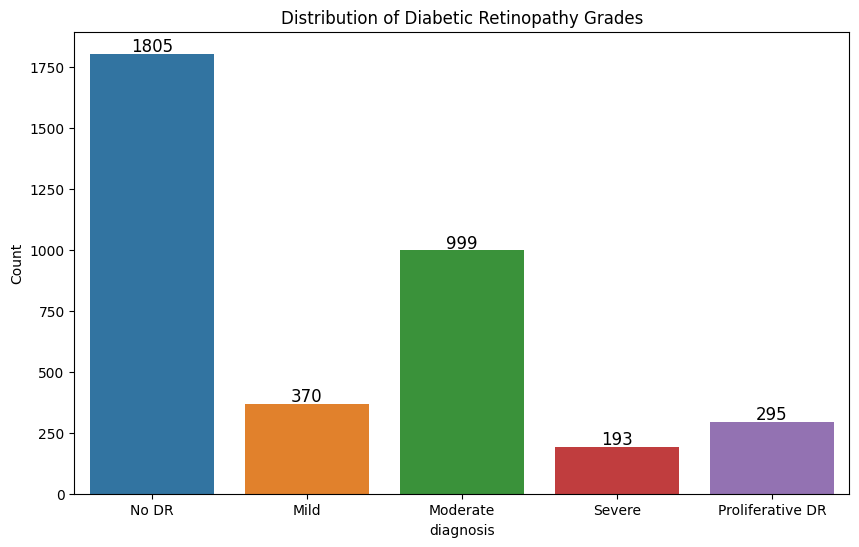

In [7]:
# Plot class distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='diagnosis', data=df)
plt.title('Distribution of Diabetic Retinopathy Grades')

diagnosis_labels = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
ax.set_xticklabels(diagnosis_labels)

plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()


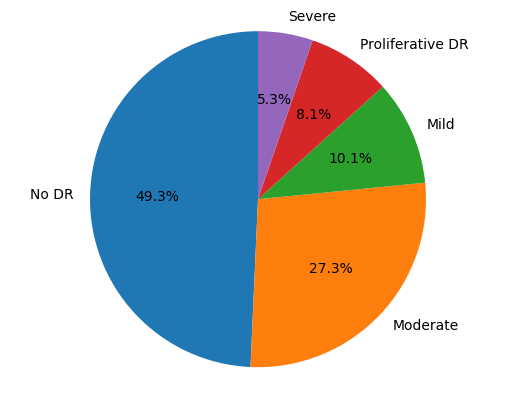

In [8]:
import matplotlib.pyplot as plt

# Your value counts
counts = df['diagnosis'].value_counts()

# Corresponding labels
labels = ['No DR', 'Moderate', 'Mild','Proliferative DR','Severe']

# Calculate percentages
percentages = [count/sum(counts) for count in counts]

# Create pie chart
fig1, ax1 = plt.subplots()
ax1.pie(percentages, labels=labels, autopct='%1.1f%%', startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')

plt.show()


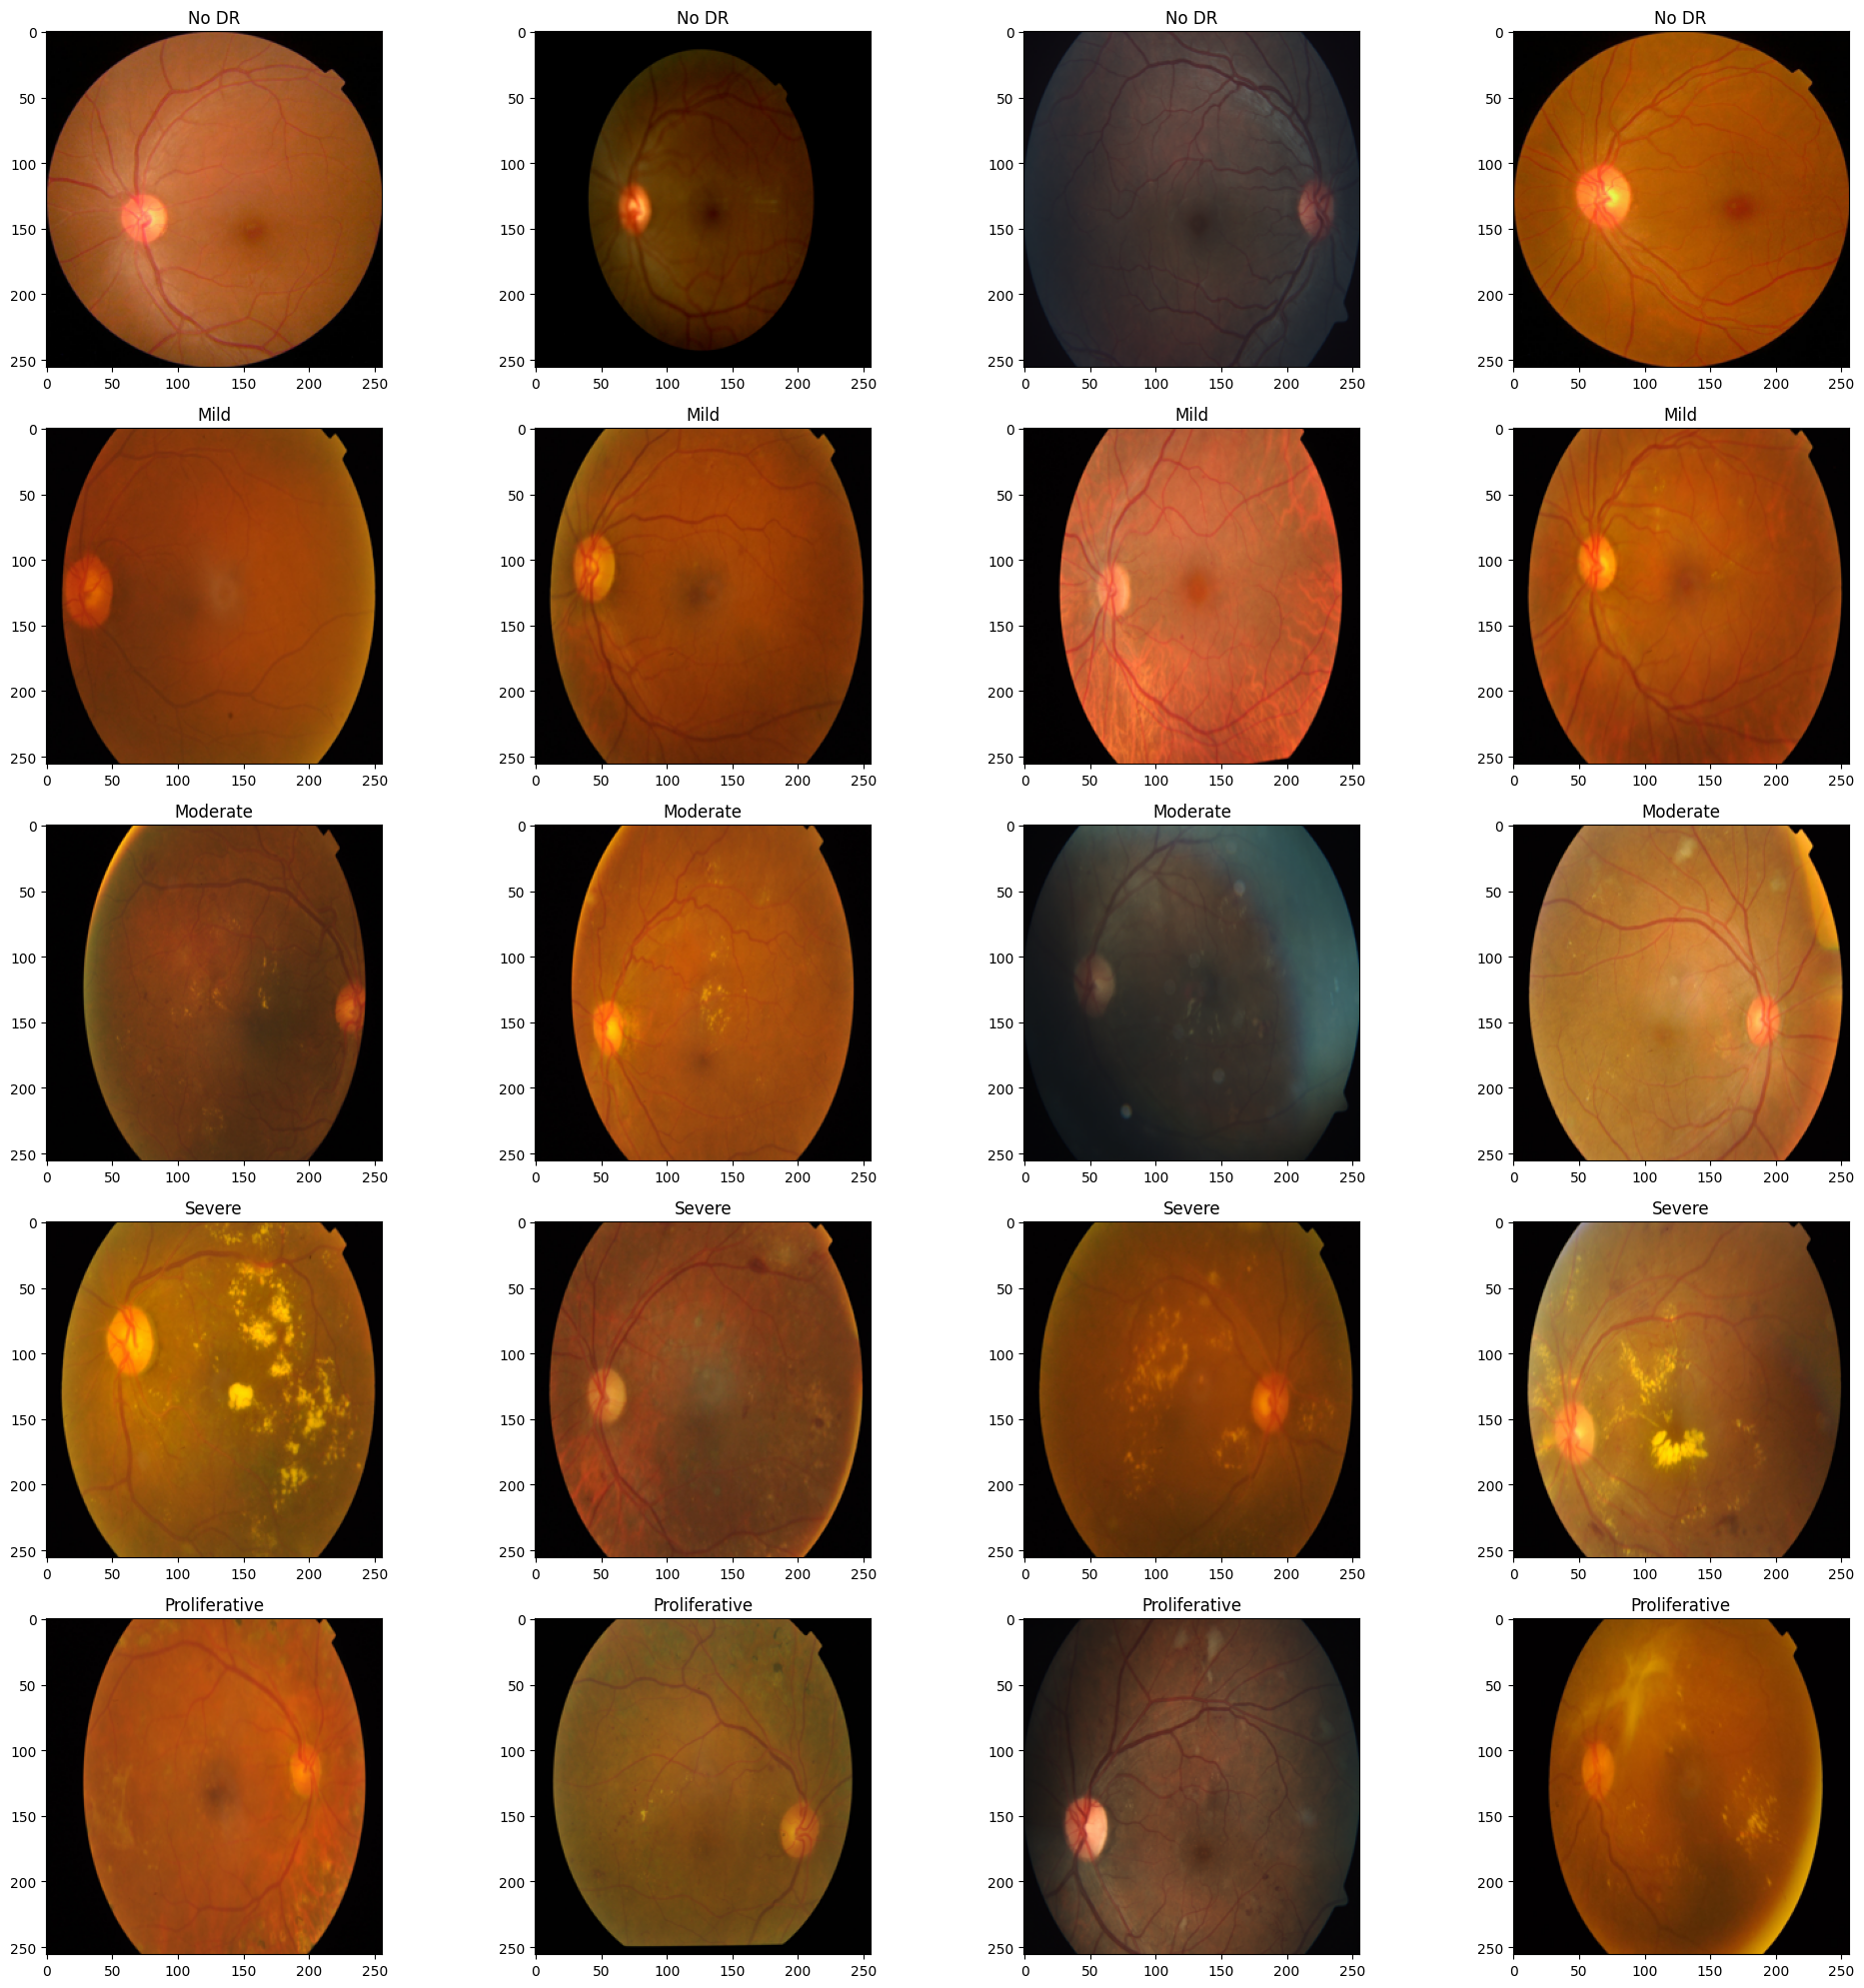

In [9]:
# Display 4 images for each of the 5 classes of DR

# Define the diagnosis classes
classes = {0: 'No DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferative'}

# Initialize a figure
fig = plt.figure(figsize=(20, 20))

# Define a standard size. You can change this as needed.
standard_size = (256, 256)

# Loop over each class
for i in range(5):
    # Get the first 4 image files of the current class
    image_files = df[df['diagnosis'] == i].iloc[:4]['id_code'].apply(lambda x: x + '.png')

    for j, image_file in enumerate(image_files):
        image_path = os.path.join('/content/drive/MyDrive/cfPublicData/aptos2/train_images', image_file)

        # Read the image
        img = Image.open(image_path)

        # Resize the image
        img_resized = img.resize(standard_size)

        # Display the image
        ax = fig.add_subplot(5, 4, i*4 + j + 1)
        ax.title.set_text(classes[i])
        plt.imshow(img_resized)

plt.tight_layout()
plt.show()


In [10]:
# Confirm labels (diagnosis descriptions / DR Grade) and class balance

# Get the counts of each diagnosis
counts = df['diagnosis'].value_counts()

# Print out the number of images for each diagnosis
for i in range(5):
    print(f"The number of images for {diagnosis_labels[i]} is: {counts[i]}\n")


The number of images for No DR is: 1805

The number of images for Mild is: 370

The number of images for Moderate is: 999

The number of images for Severe is: 193

The number of images for Proliferative DR is: 295



In [11]:
# Create a copy of the DataFrame
retina_df = df.copy()

# Rename the columns
retina_df = retina_df.rename(columns={'id_code': 'Image', 'diagnosis': 'Labels'})

# Append path and extension to filename Image
retina_df['Image'] = retina_df['Image'].apply(lambda x: '/content/drive/MyDrive/cfPublicData/aptos2/train_images/' + x + '.png')

# Define the diagnosis labels
diagnosis_labels = {0: 'No DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferative DR'}

# Replace the integer values with the diagnosis labels
retina_df['Labels'] = retina_df['Labels'].replace(diagnosis_labels)

# Display the first few rows of the DataFrame
retina_df.head()



Image            Labels
0  /content/drive/MyDrive/cfPublicData/aptos2/tra...          Moderate
1  /content/drive/MyDrive/cfPublicData/aptos2/tra...  Proliferative DR
2  /content/drive/MyDrive/cfPublicData/aptos2/tra...              Mild
3  /content/drive/MyDrive/cfPublicData/aptos2/tra...             No DR
4  /content/drive/MyDrive/cfPublicData/aptos2/tra...             No DR

In [12]:
# Confirm class balance / counts
retina_df['Labels'].value_counts()

No DR               1805
Moderate             999
Mild                 370
Proliferative DR     295
Severe               193
Name: Labels, dtype: int64

In [13]:
# Shuffle the data and split it into training and testing
retina_df = shuffle(retina_df)
train, test = train_test_split(retina_df, test_size =0.2)

In [14]:
# Data augmentation on training and test datasets
# For training datagenerator, we add normalization, shear angle, zooming range and horizontal and vertical flip
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        shear_range = 0.2,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split = 0.15)

# Normalize test data
test_datagen = ImageDataGenerator(rescale = 1./255)

In [15]:
# Datagenerators for training, validation and test datasets

train_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    subset='training')

validation_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    subset='validation')

test_generator = test_datagen.flow_from_dataframe(
    test,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32)

Found 2490 validated image filenames belonging to 5 classes.
Found 439 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


In [16]:
# ResNet configuration
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [17]:

input_shape = (256,256,3)

#Input tensor shape
X_input = Input(input_shape)

#Zero-padding

X = ZeroPadding2D((3,3))(X_input)

# 1 - stage

X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2- stage

X = res_block(X, filter= [64,64,256], stage= 2)

# 3- stage

X = res_block(X, filter= [128,128,512], stage= 3)

# 4- stage

X = res_block(X, filter= [256,256,1024], stage= 4)

# # 5- stage

# X = res_block(X, filter= [512,512,2048], stage= 5)

# Average Pooling

X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer

X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)


model = Model( inputs= X_input, outputs = X, name = 'Resnet18')


In [18]:
# Display Model
model.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1 (Conv2D)              (None, 128, 128, 64)         9472      ['zero_padding2d[0][0]']      
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1[0][0]']        

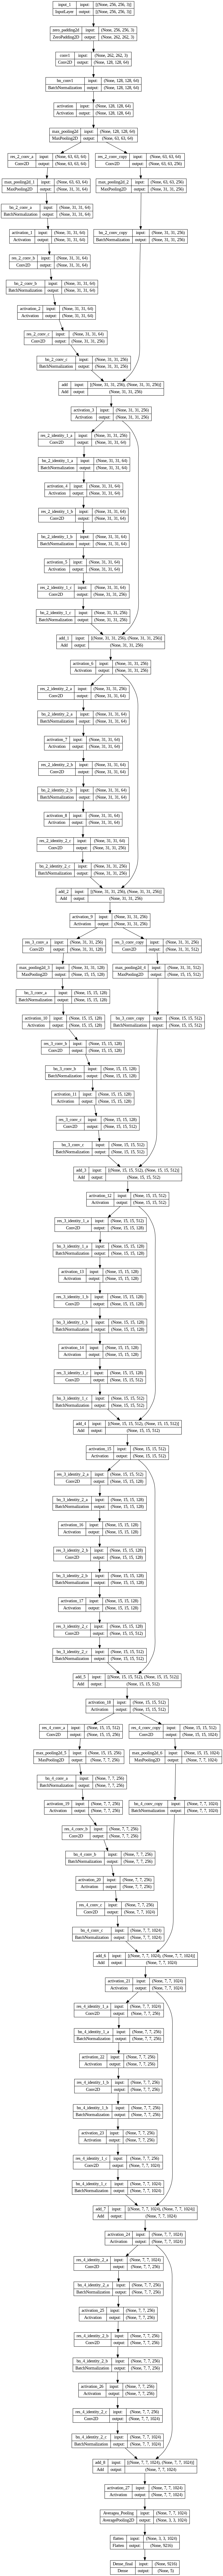

In [19]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [20]:
# Compile Model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])

In [21]:
#apply early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

#save the best model with lowest validation loss
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/cfPublicData/aptos2/weights.hdf5", verbose=1, save_best_only=True)

In [22]:
history = model.fit(train_generator, steps_per_epoch = train_generator.n // 32, epochs = 20, validation_data= validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer , earlystopping])

Epoch 1/20
77/77 [==============================] - ETA: 0s - loss: 1.7406 - accuracy: 0.6139 
Epoch 1: val_loss improved from inf to 1.56813, saving model to /content/drive/MyDrive/cfPublicData/aptos2/weights.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



77/77 [==============================] - 2597s 33s/step - loss: 1.7406 - accuracy: 0.6139 - val_loss: 1.5681 - val_accuracy: 0.1058
Epoch 2/20
77/77 [==============================] - ETA: 0s - loss: 0.8629 - accuracy: 0.6880
Epoch 2: val_loss did not improve from 1.56813
77/77 [==============================] - 420s 5s/step - loss: 0.8629 - accuracy: 0.6880 - val_loss: 1.9987 - val_accuracy: 0.1923
Epoch 3/20
77/77 [==============================] - ETA: 0s - loss: 0.8088 - accuracy: 0.7006
Epoch 3: val_loss did not improve from 1.56813
77/77 [==============================] - 398s 5s/step - loss: 0.8088 - accuracy: 0.7006 - val_loss: 1.7016 - val_accuracy: 0.2596
Epoch 4/20
77/77 [==============================] - ETA: 0s - loss: 0.7821 - accuracy: 0.7160
Epoch 4: val_loss improved from 1.56813 to 1.39008, saving model to /content/drive/MyDrive/cfPublicData/aptos2/weights.hdf5
77/77 [==============================] - 424s 6s/step - loss: 0.7821 - accuracy: 0.7160 - val_loss: 1.3901 -

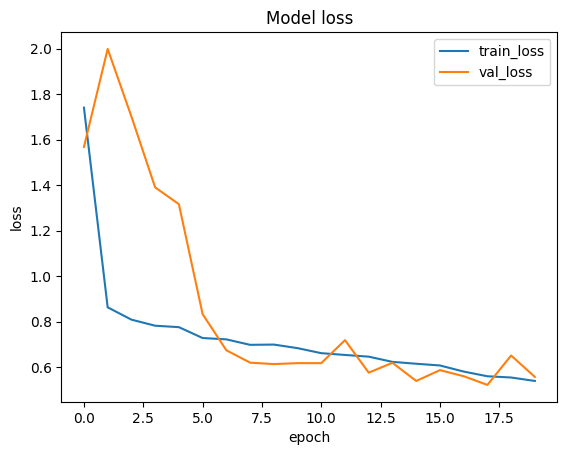

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()


In [24]:
model.load_weights("/content/drive/MyDrive/cfPublicData/aptos2/retina_weights.hdf5")

In [25]:
# Evaluate the performance of the model
evaluate = model.evaluate(test_generator, steps = test_generator.n // 32, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

22/22 [==============================] - 590s 28s/step - loss: 0.5096 - accuracy: 0.8253
Accuracy Test : 0.8252840638160706


In [26]:
# Assigning label names to the corresponding indexes
labels = {0: 'Mild', 1: 'Moderate', 2: 'No DR', 3:'Proliferative DR', 4: 'Severe'}


In [ ]:
# Loading images and their predictions

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2

prediction = []
original = []
image = []
count = 0

for item in range(len(test)):
  # code to open the image
  img= PIL.Image.open(test['Image'].tolist()[item])
  # resizing the image to (256,256)
  img = img.resize((256,256))
  # appending image to the image list
  image.append(img)
  # converting image to array
  img = np.asarray(img, dtype= np.float32)
  # normalizing the image
  img = img / 255
  # reshaping the image in to a 4D array
  img = img.reshape(-1,256,256,3)
  # making prediction of the model
  predict = model.predict(img)
  # getting the index corresponding to the highest value in the prediction
  predict = np.argmax(predict)
  # appending the predicted class to the list
  prediction.append(labels[predict])
  # appending original class to the list
  original.append(test['Labels'].tolist()[item])


In [28]:
# Getting the test accuracy
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.8281036834924966


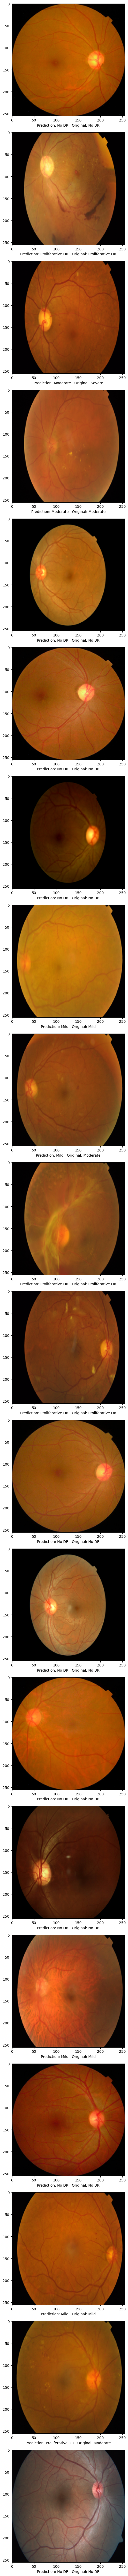

In [29]:
# Visualizing the results
import random
fig=plt.figure(figsize = (100,100))
for i in range(20):
    j = random.randint(0,len(image))
    fig.add_subplot(20, 1, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

In [30]:
print(classification_report(np.asarray(original), np.asarray(prediction)))


                  precision    recall  f1-score   support

            Mild       0.69      0.56      0.61        63
        Moderate       0.72      0.82      0.77       198
           No DR       0.95      0.97      0.96       380
Proliferative DR       0.57      0.54      0.56        57
          Severe       0.69      0.26      0.37        35

        accuracy                           0.83       733
       macro avg       0.72      0.63      0.66       733
    weighted avg       0.82      0.83      0.82       733



Text(0.5, 1.0, 'Confusion_matrix')

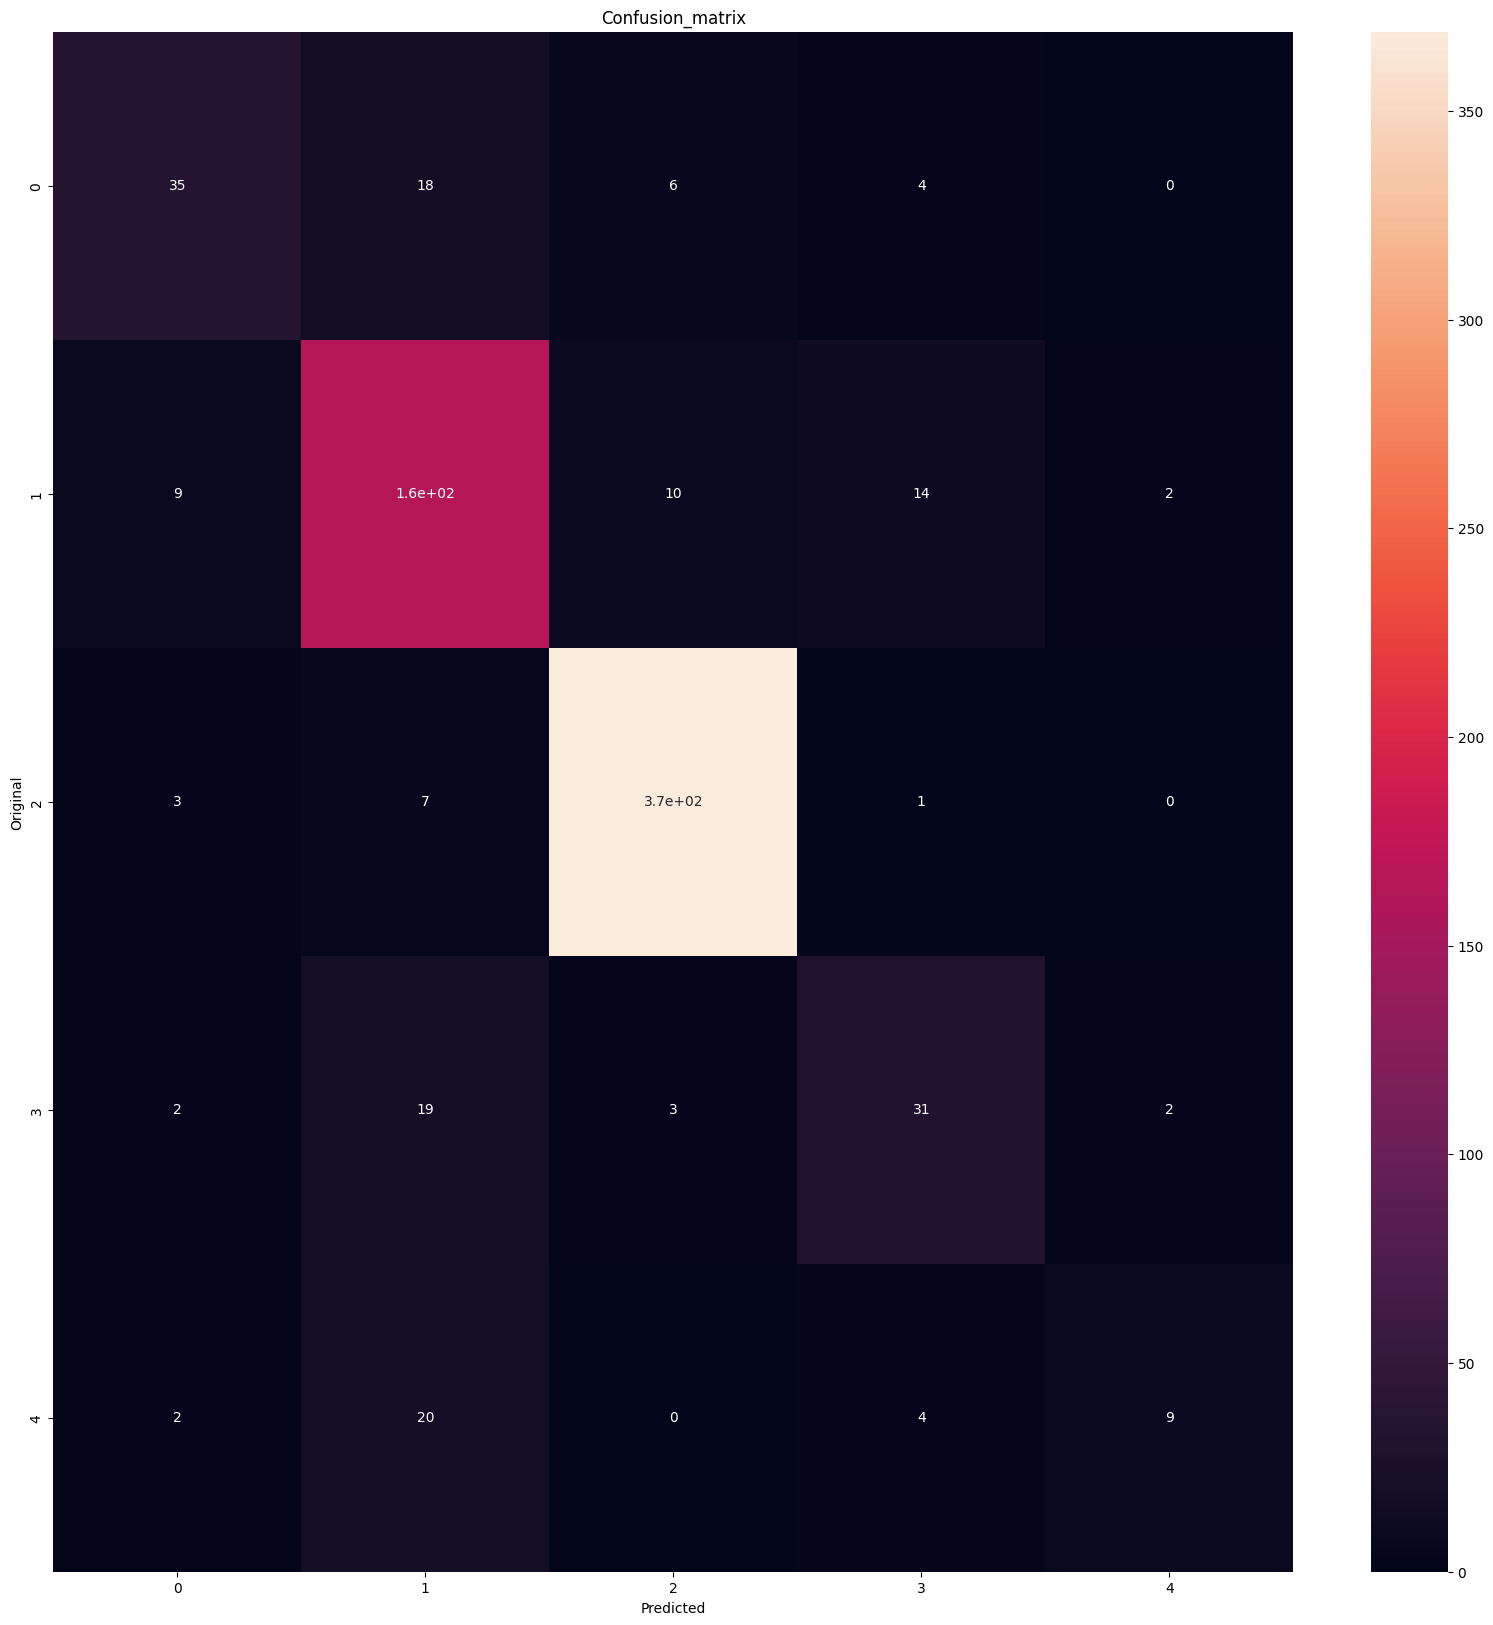

In [31]:
plt.figure(figsize =(20,20))
cm = confusion_matrix(np.asarray(original), np.asanyarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')